# Бейзлайн для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Советы:
0. Заполнить аккаунт н Каггл: фото + статус Contributor
1. Сделайте стабильную валидацию
2. Тестируйте 1 изменение за раз
3. Не переусердствуйте с подбором гиперпараметров модели. Делайте это 1 раз вначале и 1 раз в конце
4. Прирост качества в основном зависит от __очистки данных__ и __генерации фич__, а не от модели
5. Бывает полезно удалить "мусорные" фичи. Определить их можно, например, через feature importance

Дедлайны и требования:
- Соревнование заказнчивается 29 апреля
- Необходимо получить R2 > 60% на __Private__ Leaderboard для успешного завершения курса
- Необходимо получить ранг "Contributor" в соревнованиях на Каггле: https://www.kaggle.com/progression
- Прислать в комментариях к ДЗ ссылка на решение проекта в git / public kaggle notebook

Переобучение

1. Большая разница между R2 на train и кросс-валидации
2. Большая разница между R2 на кросс-валидации и Public Leaderbord

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


4

In [3]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [5]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [6]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [7]:
X.loc[X['Rooms']==5] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,B,B,17,3079,59,2890.0,0,8,B
1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,4508.0,3,7,B
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B
6358,27,5.0,42.003293,NaN,0.0,5,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B
4070,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,B,B,25,5487,3,NaN,0,4,B
2879,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,B,B,21,4346,2,165.0,1,2,B


In [8]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [9]:
#X.loc[X['KitchenSquare']==1] 

**Floor, HouseFloor**

In [10]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [11]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [12]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [13]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [14]:
#X[X['HouseYear'] < 1].head()

### Заполнение NaN

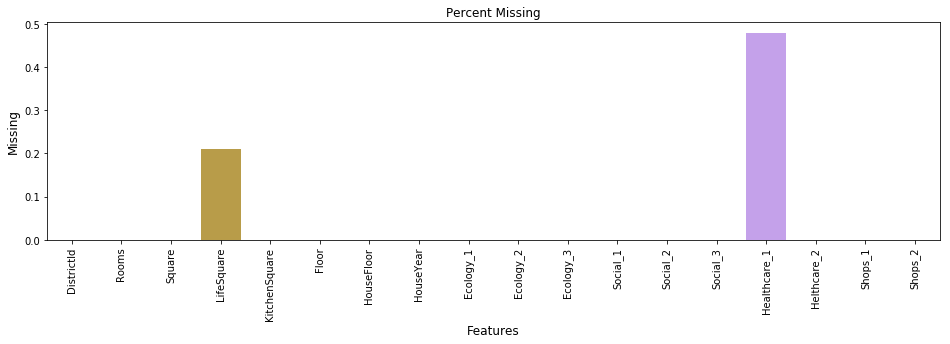

In [15]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [16]:
X.DistrictId.nunique()

205

In [17]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '101': 97,
 '47': 97,
 '99': 97,
 '13': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '88': 64,
 '128': 64,
 '12': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '63': 43,
 '124': 43,
 '42': 42,
 '79': 42,
 '113': 41,
 '109': 41,
 '77': 40,
 '54': 37,
 '15': 36,
 '38': 36,
 '24': 35,
 '56': 34,
 '32': 34,
 '5': 34,
 '103': 33,
 '123': 32,
 '80': 31,
 '83': 31,
 '19': 31,
 '33': 31,
 '69': 29,
 '138': 29,
 '130': 29,
 '64': 28,
 '86': 27,
 '70': 27,
 '87': 27,
 '108': 

In [18]:
X[X['DistrictId']=='159']


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
9970,159,3.0,61.809022,40.444725,6.0,2,9.0,1972,0.015017,B,B,17,3079,59,2890.0,0,8,B
8921,159,3.0,69.589661,48.856723,5.0,1,3.0,1930,0.037316,B,B,32,6748,93,562.0,4,10,B
15272,159,2.0,56.291983,33.143706,9.0,10,10.0,2008,0.015017,B,B,17,3079,59,2890.0,0,8,B
2574,159,2.0,43.439367,29.328888,6.0,5,8.0,1935,0.246624,B,B,14,2940,45,NaN,3,6,B
1268,159,4.0,88.947262,64.483490,7.0,6,6.0,1933,0.246624,B,B,14,2940,45,NaN,3,6,B
14367,159,3.0,67.254429,47.390472,6.0,5,7.0,1950,0.246624,B,B,14,2940,45,NaN,3,6,B


# 2. Очистка данных

In [19]:
X['KitchenSquare'].median()

6.0

In [20]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        #X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] =  X.loc[X['KitchenSquare'] > 1000, 'Square'] / 10  # можно median
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] =  self.medians['KitchenSquare']  # можно median
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year - 1
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [21]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [22]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,B,...,33,7976,5,0,11,B,0,0,0,0
15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,B,...,46,10309,1,1,16,B,0,0,0,0
4765,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,B,...,34,7759,0,1,3,B,0,0,0,0
5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,B,...,23,5735,3,0,5,B,0,0,0,0
10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,B,...,35,5776,1,2,4,B,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,5.0,5.0,1968,0.135650,B,...,46,7960,6,3,11,B,0,1,0,0
6159,18,1.0,41.521546,20.539216,9.0,13.0,13.0,2000,0.000000,B,...,30,5562,0,0,5,A,0,0,0,0
5123,27,1.0,47.939008,41.939008,3.0,12.0,16.0,2015,0.072158,B,...,2,629,1,0,0,A,0,0,0,1


# 3. Feature engineering

In [23]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        


        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        #elif self.med_price_by_floor_year is not None:
        #    X = X.merge(self.med_price_by_floor_year, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        #elif self.med_price_by_district is not None:
        #    X = X.merge(self.med_price_by_district, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan

        X.loc[X['Floor'] == 1, 'floor_cat'] = 1                       # Первый этаж
        X.loc[(X['Floor'] >= 2) & (X['Floor'] <= 5), 'floor_cat'] = 2 # Этажы для пенсионеров (обычно полльзуются спросом больше)
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        X.loc[X['HouseYear'] < 1918, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1918) & (X['HouseYear'] <= 1941), 'year_cat'] = 2 
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1950), 'year_cat'] = 3 # Привязал к выпускаемым сериям домов более подробно https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D1%80%D0%B8%D0%B8_%D0%B6%D0%B8%D0%BB%D1%8B%D1%85_%D0%B4%D0%BE%D0%BC%D0%BE%D0%B2
        X.loc[(X['HouseYear'] > 1950) & (X['HouseYear'] <= 1955), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 1955) & (X['HouseYear'] <= 1960), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 1960) & (X['HouseYear'] <= 1970), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 1970) & (X['HouseYear'] <= 1980), 'year_cat'] = 7
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 1990), 'year_cat'] = 8
        X.loc[(X['HouseYear'] > 1990) & (X['HouseYear'] <= 2000), 'year_cat'] = 9
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 10
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 11
            
        return X
            
    

In [24]:
features = FeatureGenerator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


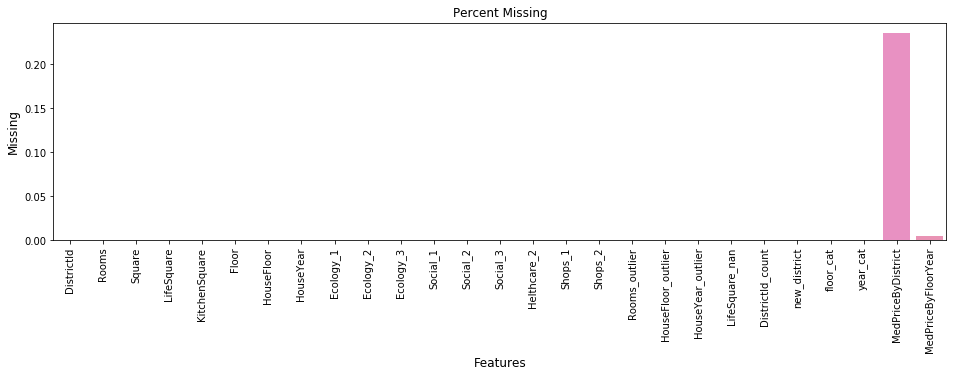

In [25]:

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

In [26]:
X[X['DistrictId']=='35']

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.08904,1,...,0,0,0,0,5.0,1,3.0,6.0,NaN,191814.836524
412,35,3.0,63.851403,47.245735,6.0,7.0,9.0,1971,0.08904,1,...,0,0,0,0,5.0,1,3.0,7.0,NaN,177511.314827
556,35,1.0,47.410775,41.410775,3.0,4.0,13.0,1977,0.08904,1,...,0,1,0,1,5.0,1,2.0,7.0,NaN,170289.343845
2764,35,2.0,43.325817,22.487877,6.0,7.0,14.0,1969,0.08904,1,...,0,0,0,0,5.0,1,3.0,6.0,NaN,191814.836524
3097,35,1.0,46.287195,40.287195,3.0,12.0,12.0,2015,0.08904,1,...,0,1,0,1,5.0,1,4.0,11.0,NaN,169539.734784
4108,35,2.0,48.249779,29.473633,6.0,3.0,9.0,1971,0.08904,1,...,0,0,0,0,5.0,1,2.0,7.0,NaN,170289.343845
4269,35,1.0,34.182426,18.185922,5.0,7.0,9.0,1977,0.08904,1,...,0,0,0,0,5.0,1,3.0,7.0,NaN,177511.314827
4799,35,1.0,35.868954,19.586919,9.0,16.0,16.0,1984,0.08904,1,...,0,0,0,0,5.0,1,5.0,8.0,NaN,237650.719925
5645,35,1.0,42.348253,36.348253,3.0,9.0,16.0,2015,0.08904,1,...,0,0,0,1,5.0,1,3.0,11.0,NaN,166486.382416
6147,35,4.0,101.392298,66.600047,10.0,17.0,22.0,1998,0.08904,1,...,0,0,0,0,5.0,1,5.0,9.0,NaN,253641.469149


In [27]:
#remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
#                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
#                   'HouseFloor', 'HouseYear',
#                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
#                  'MedPriceByDistrict',
#                  'MedPriceByFloorYear']
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                    'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                  'DistrictId_count',  'Shops_2']
X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

In [28]:
#model = LGBMRegressor(max_depth=7,
#                             min_samples_leaf=10,
#                             n_estimators=300,
#                             random_state=42)
model = LGBMRegressor(max_depth=7, num_leaves=15,
                             n_estimators=300,
                             random_state=42)
cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.741 +- 0.018


In [29]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

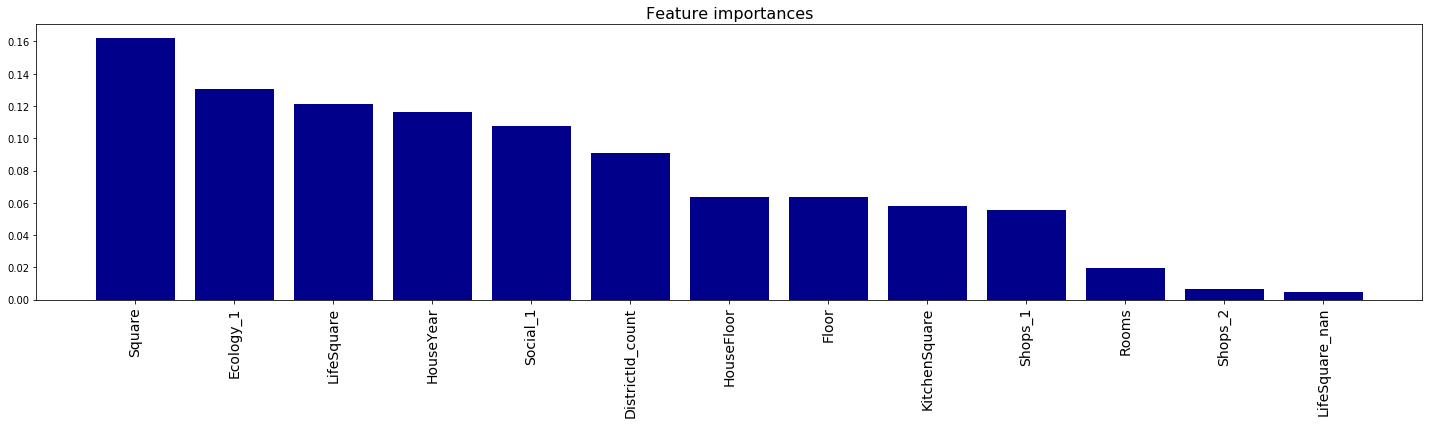

In [30]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [31]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,155198.945341
1,15856,233074.340925
2,5480,219978.915756
3,15664,349390.674242
4,14275,142655.626434


In [32]:
preds_final.shape

(5000, 2)

In [33]:
model2 = LGBMRegressor(max_depth=7, min_samples_leaf=10, n_estimators=300, random_state=42)

cv_score2 = cross_val_score(model, X_final, y_pred_final, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean2 = cv_score2.mean()
std2 = cv_score2.std()

print('R2: {:.3f} +- {:.3f}'.format(mean2, std2))

R2: 0.972 +- 0.003
